This notebook provides аn example of an algorithm for producing continuous futures data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
underlying = 'NQ'
contracts = ['M0', 'U0', 'Z0', 'H1', 'M1', 'U1', 'Z1']

In [ ]:
def daily_volumes(ticker):
    """
    Reading data and daily volumes calculation
    """
    # You need to insert the path to the data file
    candles = pd.read_csv(r'..\\'+ ticker +'.csv', sep = ';')
    #All datasets for this course are available at this link:
    #https://drive.google.com/drive/folders/1mhbVjuwNZGX9nmZuCxJStBmraF3HIzio?usp=sharing

    candles['timestamp'] = pd.to_datetime(candles['timestamp'], format = "%Y-%m-%dT%H:%M:%SZ")
    candles = candles.set_index('timestamp')

    candles = candles[~candles.index.duplicated(keep='first')]
    candles = candles.sort_index()

    daily_candles = candles[['volume']]
    daily_candles = daily_candles.resample('1D').sum()
    return candles, daily_candles

Algorithm for making a continuous futures from data for the original individual contracts:

2020-06-15 00:00:00
2020-09-14 00:00:00
2020-12-14 00:00:00
2021-03-15 00:00:00
2021-06-14 00:00:00
2021-09-13 00:00:00


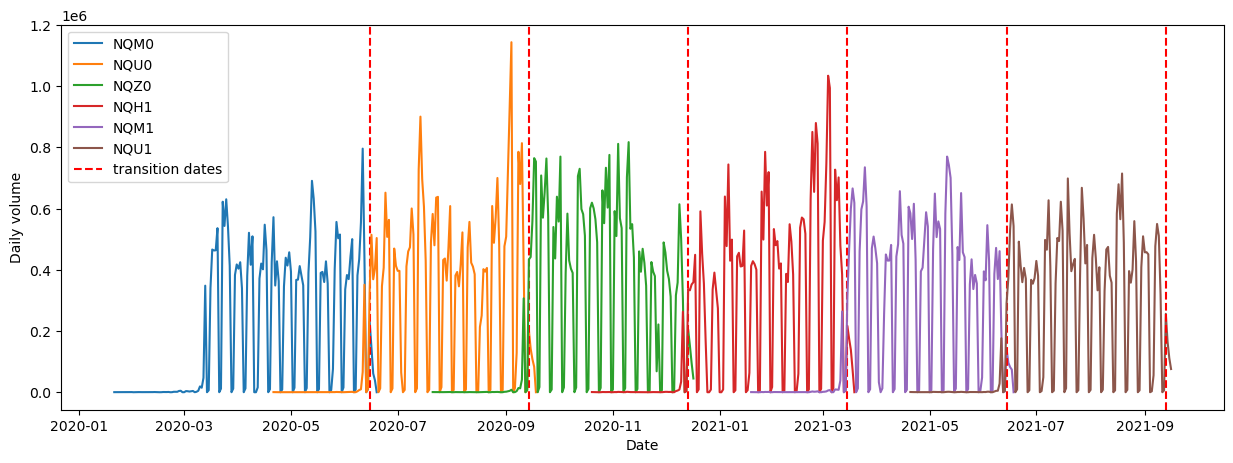

In [ ]:
candles = pd.DataFrame()
plt.figure(figsize = (15, 5))
futures_merge_dates = []

for i in np.arange(len(contracts)-1):
    ticker1 = underlying + contracts[i]
    ticker2 = underlying + contracts[i+1]

    candles1, daily_candles1 = daily_volumes(ticker1)
    candles2, daily_candles2 = daily_volumes(ticker2)

    plt.plot(daily_candles1.index, daily_candles1['volume'], label=ticker1)

    if candles.shape[0] == 0:
        candles = candles1

    # We calculate sum and diff over the entire time period, but not at any given time both futures exist
    # Therefore we do merge 'outer' and fill NaN as 0, because at that moment the futures are not traded
    vols = daily_candles1.merge(daily_candles2, how = 'outer', left_index = True, right_index = True).fillna(0)
    vols['diff'] = vols['volume_y']-vols['volume_x']
    vols['sum'] = vols['volume_y']+vols['volume_x']

    # The first part of the logical expression is responsible for detecting the moments in time when trading on both futures becomes small
    # At this moment, nothing needs to be done, it could be a weekend or something else, but not necessarily a transition of volumes
    # The second part of the expression is responsible for detecting the transition of volumes from one futures to another
    # the graph will be presented below
    vols['check'] = (vols['sum']>vols['sum'].ewm(10).mean())*(vols['diff']>0)

    futures_merge_date = vols.index[vols['check'] == True][0]

    if i == len(contracts) - 2:
        plt.axvline(futures_merge_date, color = 'red', linestyle='--', label='transition dates')
    else:
        plt.axvline(futures_merge_date, color = 'red', linestyle='--')

    candles = pd.concat([candles[:futures_merge_date], candles2[futures_merge_date:]])
    print(futures_merge_date)
    futures_merge_dates.append(futures_merge_date)

candles = candles[~candles.index.duplicated(keep='first')]
candles = candles.sort_index()

plt.ylabel('Daily volume')
plt.xlabel('Date')
plt.legend()
plt.show()

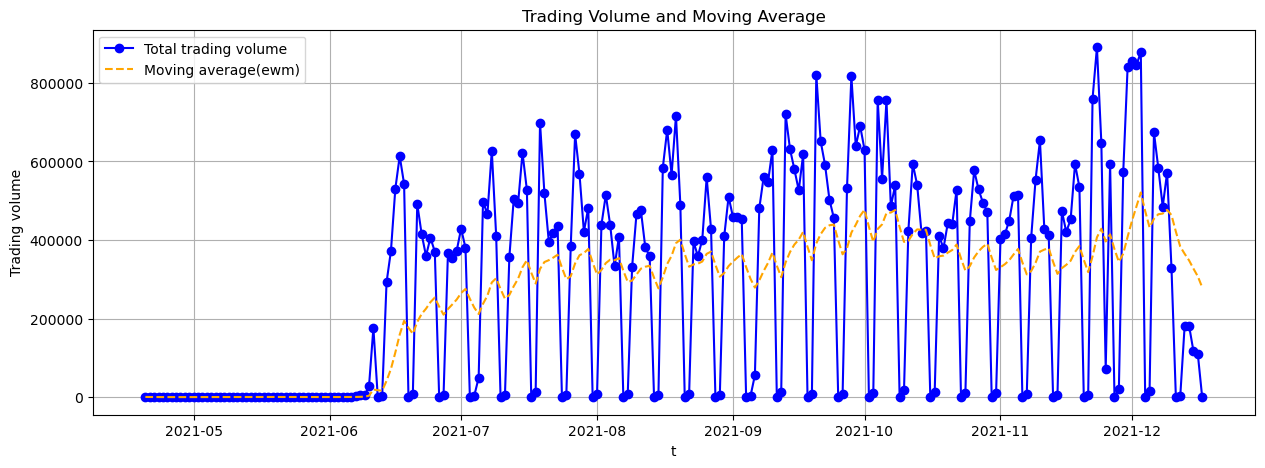

In [ ]:
# Plotting graphs
ticker1 = underlying + contracts[5]
ticker2 = underlying + contracts[6]

candles1, daily_candles1 = daily_volumes(ticker1)
candles2, daily_candles2 = daily_volumes(ticker2)

# The first part of the logical expression is responsible for detecting the moments in time when trading on both futures becomes small
# At this moment, nothing needs to be done, it could be a weekend or something else, but not necessarily a transition of volumes
# The second part of the expression is responsible for detecting the transition of volumes from one futures to another
# the graph will be presented below
vols = daily_candles1.merge(daily_candles2, how = 'outer', left_index = True, right_index = True).fillna(0)
vols['diff'] = vols['volume_y']-vols['volume_x']
vols['sum'] = vols['volume_y']+vols['volume_x']

plt.figure(figsize=(15, 5))
plt.plot(vols.index, vols['sum'], label='Total trading volume', color='blue', marker='o')
plt.plot(vols.index, vols['sum'].ewm(10).mean(), label='Moving average(ewm)', color='orange', linestyle='--')

# Setting up the graph
plt.title('Trading Volume and Moving Average')
plt.xlabel('t')
plt.ylabel('Trading volume')
plt.legend()
plt.grid()

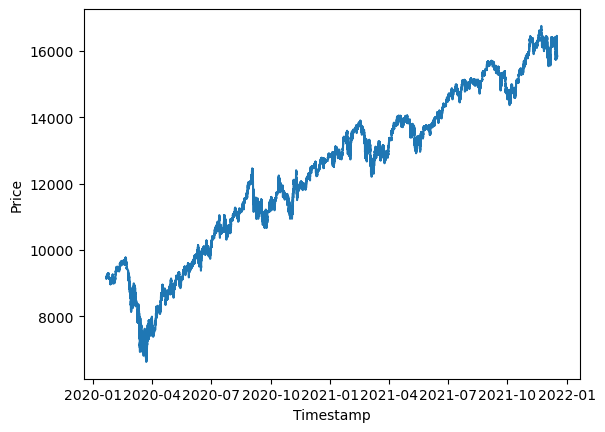

In [ ]:
plt.plot(candles['close'])
plt.ylabel('Price')
_ = plt.xlabel('Timestamp')

Additional exercises and research topics:

1. Explore different methods of financial data aggregation in terms of information transfer, augmentation potential, and usefulness for developing algorithmic strategies